# Prototype Half Term Report

## Introduction

In [12]:
from functools import reduce

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from matplotlib import pyplot as plt
import numpy as np
from operator import add
import pandas as pd
import pickle as pkl

from sklearn.preprocessing import LabelBinarizer


%matplotlib inline

In [2]:
df = pd.read_csv('data/gigawordeng/abridged.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = ['headline', 'story']

## Data Exploration
### Proportion summarised

We want to find the share that each word in each story creates for every headline that is generated, this will eventually come to show how compact our model will be.

#### Prep 

In [3]:
def len_each_cell (dataframe):
    """
    Find num words for each cell in a dataframe
    """
    return dataframe.applymap(lambda text: len(text.split()))

def prop_for_all_story (dataframe):
    """
    Finds the porportion of the summarisation 
    verses story by length
    """
    tmp = len_each_cell(dataframe)
    return tmp['headline'] / tmp['story']

Flatten all lists, so we may find the number of elements for each key in every dictionary

In [4]:
%%time
plot = prop_for_all_story(df)

Wall time: 514 ms


#### Result

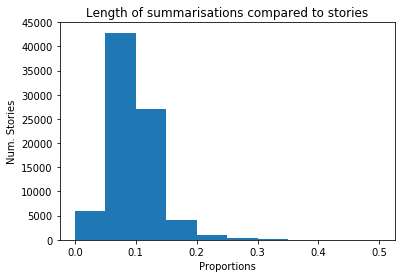

In [5]:
plt.hist(plot, range=(0,0.5))
plt.title('Length of summarisations compared to stories')
plt.xlabel('Proportions')
plt.ylabel('Num. Stories')
plt.show()
del plot

It seems that the headlines themselves are unsurprisingly heavily condensed in relation to the story.

### Most popular words...

With an analysis of the most popular words, we may be able to see general words that the headlines may concerntrate towards.

#### Prep

In [6]:
def pop_words(df, key, cutoff, stopwords=False):
    """
    Finds the most popular words from the data
    """
    from sklearn.feature_extraction.text import CountVectorizer
    
    if stopwords == False:
        cv = CountVectorizer(stop_words='english')
    else:
        cv = CountVectorizer()
        
    bag_of_words = cv.fit_transform(df[key])
    sum_words = bag_of_words.sum(axis=0)
    vocab = cv.vocabulary_.items()
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocab]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:cutoff]

def plot_word_counts(key):
    words = list(zip(*pop[key]))[0]
    counts = list(zip(*pop[key]))[1]
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title('Most popular words for ' + key)
    return pd.Series(counts, index=words).plot.barh()

In [7]:
%%time
pop = {'headline':None,
       'story':None}

pop = {key : pop_words(df,key, 10) 
       for key in pop}

Wall time: 5.67 s


#### Result

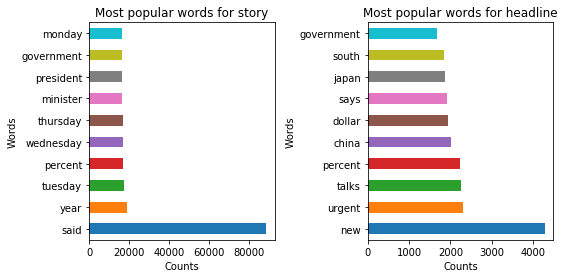

In [8]:
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
plt.subplot(1,2,1)
plot_word_counts('story')
plt.subplot(1,2,2)
plot_word_counts('headline')
plt.show()

It's interesting to note that `said` corresponds to `says` instead, from this, we can speculate that most headlines tend to go towards present tense.

`Story` has a large concerntration of time words, but that is unsurprising due to us only taking only the first few sentences of the story. The headlines themselves tend to not have any time words, however there is a tendency to use nouns.

We should analyse popular parts of speech for each text.

### Popular parts of speech tags for each key

With an analysis of parts of speech, we should be able to see the patterns in word selection that the machine algorithm may tends towards.

#### Prep

In [9]:
from nltk import pos_tag, word_tokenize

def speech_tag_df(text):
    """
    Convert each text into only parts of speech tags
    """
    tag = pos_tag(word_tokenize(text), tagset='universal')
    return ' '.join([
        pos 
        for word, pos in tag
    ])

def pop_tags(df, key, cutoff, stopwords=False):
    """
    Finds the most popular words from the data
    """
    from sklearn.feature_extraction.text import CountVectorizer
    
    if stopwords == False:
        cv = CountVectorizer(stop_words='english')
    else:
        cv = CountVectorizer()
        
    bag_of_words = cv.fit_transform(tagged_df[key])
    sum_words = bag_of_words.sum(axis=0)
    vocab = cv.vocabulary_.items()
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocab]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:cutoff]


def plot_tagged_counts(key):
    words = list(zip(*pop_tags_[key]))[0]
    counts = list(zip(*pop_tags_[key]))[1]
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.title('Most popular tags for ' + key)
    return pd.Series(counts, index=words).plot.barh()

In [10]:
%%time
tagged_df = df.applymap(speech_tag_df)

Wall time: 25min 46s


In [11]:
%%time
pop_tags_ = {
    'headline':None,
    'story':None
}

pop_tags_ = {key : pop_tags(tagged_df,key, 10) 
             for key in pop_tags_}

Wall time: 4.53 s


#### Result

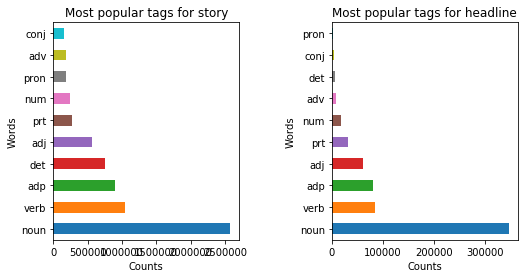

In [12]:
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
plt.subplot(1,2,1)
plot_tagged_counts('story')
plt.subplot(1,2,2)
plot_tagged_counts('headline')
plt.show()

As mentioned above, the most popular parts of speech are nouns, however, this is by a larger margin within the headlines.

The headlines also tend to only go towards more descriptive parts of words, such as adjectives, verbs and nouns. This is notable with the considerable drop in usage of determiners, which are quite popular in the stories.

Verbs, adpositions and adjectives all keep their usage ranks, however there is a notable drop in verb proportion.

### Portions of words in headline that are in first few sentences

With this information, we may see the relevance of each sentence to the generation of the headline, this may fundamentally mean that we may cut the number of sentences that we include.

I am not going to compare sets of words of the sentences, as there may be duplicate words which may influence how the headline is generated.

#### Prep

In [3]:
from nltk import word_tokenize
import re

# Due to memory limits, I have to limit the amount of stories we can take
df2 = pd.read_csv('data/gigawordeng/less_abridged.csv')[:int(len(df) * (2/5))]
df2 = df2.drop(['Unnamed: 0'], axis=1)
print('Sample size: {}'.format(len(df2)))

Sample size: 32671


In [5]:
import string
table = str.maketrans('', '', string.punctuation)

split_w_no_punc = lambda text: str(text).translate(table).split()

def compare_sent_to_headline():
    comparisons = np.zeros((len(df2), 5))
    lists = df2.applymap(split_w_no_punc)
    headlines = lists['headline']
    lists = lists.drop(['headline'],axis=1)
    
    for i, row in lists.iterrows():
        headline = headlines.iloc[i]
        for j, sentence in enumerate(row):
            intersect = [word for word in headline if word in sentence]
            try:
                comparisons[i][j] = len(intersect) / len(sentence)
            except ZeroDivisionError:
                print("No words at: "+str((i, j)))
                comparisons[i][j] = 0
            
    return comparisons

In [6]:
%%time
comparisons = compare_sent_to_headline()

No words at: (4799, 4)
No words at: (6245, 3)
No words at: (6940, 0)
No words at: (6943, 0)
No words at: (6945, 0)
No words at: (6947, 0)
No words at: (7232, 0)
No words at: (7299, 0)
No words at: (7301, 0)
No words at: (7304, 0)
No words at: (7307, 0)
No words at: (7309, 0)
No words at: (7310, 0)
No words at: (7315, 0)
No words at: (7406, 0)
No words at: (7408, 0)
No words at: (7409, 0)
No words at: (8134, 1)
No words at: (8134, 4)
No words at: (8327, 0)
No words at: (10318, 4)
No words at: (11974, 0)
No words at: (12503, 3)
No words at: (14814, 1)
No words at: (14814, 4)
No words at: (17446, 3)
No words at: (18523, 2)
No words at: (18817, 4)
No words at: (19237, 3)
No words at: (21303, 0)
No words at: (21348, 3)
No words at: (23331, 1)
No words at: (23331, 4)
No words at: (25248, 3)
No words at: (27183, 1)
No words at: (27183, 4)
No words at: (28020, 2)
No words at: (29482, 0)
No words at: (29765, 3)
No words at: (30993, 0)
No words at: (31364, 2)
No words at: (31676, 0)
Wall time: 3

In [7]:
df2.iloc[4799][5]

'---'

In [8]:
df2.iloc[6245][4]

'-----'

It appears that these empty strings are due to line separators in the stories. We could clean our dataset to account for these, however they make a very small portion of the data, so we can ignore these.

In [9]:
%%time
comparisons = pd.DataFrame(comparisons)
comparisons = comparisons.rename(columns={
    sent_num:'sent'+str(int(sent_num)+1)
    for sent_num in list(comparisons)
})

Wall time: 2 ms


#### Result

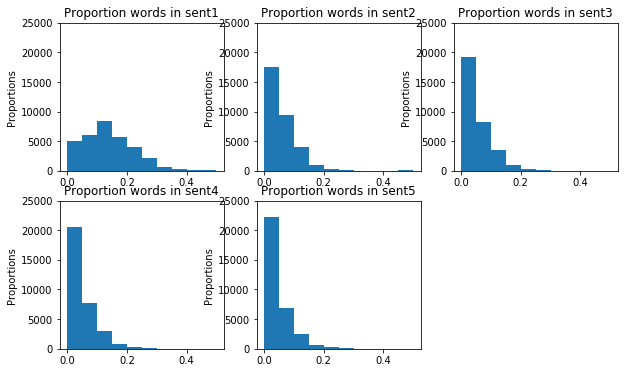

In [10]:
plt.figure(figsize=(10,6))
for i, key in enumerate(list(comparisons)):
    plt.subplot(2,3,i+1)
    plt.ylim(0, 25000)
    comparisons[key].plot.hist(range=(0,0.5))
    plt.title('Proportion words in ' + key)
    plt.ylabel('Proportions')

plt.show()

We could deduce from this that the most informative sentence remains to be the first one, with the tails on each concurrent sentence to be slimming, it's therefore worth to only keep the first three sentences for performance reasons.

In [11]:
del df2, comparisons

## Baseline
#### Prep

In [4]:
%%time
df = pd.read_csv('data/gigawordeng/abridged.csv')

X_chars = set(char for text in df['story'] for char in text)
y_chars = set(char for text in df['headline'] for char in text)

X_chars = sorted(list(X_chars))
y_chars = sorted(list(y_chars))

seqlen_X = max([len(text) for text in df['story']])
seqlen_y = max([len(text) for text in df['headline']])

# I added '1' as last params for enumerate to account for 0 as equivalent 
# to a none value
char_index_X = dict([(char, i) for i,char in enumerate(X_chars, 1)])
char_index_y = dict([(char, i) for i,char in enumerate(y_chars, 1)])
index_char_X = dict([(i, char) for i,char in enumerate(X_chars, 1)])
index_char_y = dict([(i, char) for i,char in enumerate(y_chars, 1)])

Wall time: 2.55 s


#### Encode X

In [5]:
tmp = df['story'].map(lambda text: [char_index_X[char] for char in text])
tmp = pad_sequences(tmp, maxlen = seqlen_X, padding='post')
enc_X = np.reshape(tmp, (len(df), seqlen_X, 1))
del tmp

I included this after I encoded `y` below, I figured that I wanted to use a Keras data generator, these require the data to be split up 1 to 1. 

In [6]:
%%time

"""
This block encodes the X values as arrays of 32 bit integers
and saves them into disk as separate files
"""
import gzip
import gc 

num_files = 13
file_batch_size = int(len(df)/num_files)
for i in range(num_files):
    print('I\'m up to partition {}'.format(i))
        
    enc_X_tmp = enc_X[i*file_batch_size:(i+1)*batch_size]

    with gzip.open('temp/enc_X/'+str(i)+'.gz', 'wb+') as fh:
        fh.write(enc_X_tmp.data)
        
    del enc_X_tmp

I'm up to partition 0
I'm up to partition 1
I'm up to partition 2
I'm up to partition 3
I'm up to partition 4
I'm up to partition 5
I'm up to partition 6
I'm up to partition 7
I'm up to partition 8
I'm up to partition 9
I'm up to partition 10
I'm up to partition 11
I'm up to partition 12
Wall time: 1min 42s


We'll access it like so:

```python
with gzip.open('temp/enc_X/0', 'rb') as f:
    tmp = f.read()
    
arr0 = np.fromstring(tmp, dtype='int32').reshape((6283, 2316, 1))
```

#### Encode y

_Experiment with numpy datatypes_

In [10]:
np.zeros([1,2]).dtype

dtype('float64')

In [11]:
test = np.zeros([1,2], 'bool_')
test[0][1] = 1
test

array([[False,  True]])

In [12]:
# Being only 1 byte I was thinking that this would overflow into a False
test[0][0] = 9
test

array([[ True,  True]])

~~Because we are essentially just storing 1's and 0's, I'm going to assign the arrays to `signed int 8 byte` to save space, I'm not going to assign them to `bool_ 1 byte` because it may cause more headache with how Keras might handle that further down the line, there's not a lot of documentation about it.~~

I'm going to assign them to `bool_`, it appears that numbers passed through the array performs as expected

In [7]:
%%time
"""
This block encodes the y values as arrays of single byte elements 
and saves them into disk as 13 separate files

Initially, I've saved them as elements of 64 bit floats, 
and this resulted in files 8mb files of 0s and 1s 
compared to the current 1mb files and a 5 time speed increase
"""

import gc
import gzip

y = df['headline']
for i in range(num_files):
    print('I\'m up to partition {}'.format(i))
    dec_X = np.zeros((file_batch_size, seqlen_y, len(y_chars)+1),dtype='bool_')
    dec_y = np.zeros((file_batch_size, seqlen_y, len(y_chars)+1),dtype='bool_')
    for j, headline in enumerate(y[i*batch_size:(i+1)*batch_size]):
        for k, char in enumerate(headline):
            dec_X[j, k, char_index_y[char]] = 1.
            if k > 0:
                dec_y[j, k-1, char_index_y[char]] = 1.

    print('\tWriting dec_X')

    with gzip.open('temp/dec_X/'+str(i)+'.gz', 'wb+') as fh:
        fh.write(dec_X.data)
    del dec_X   

    print('\tWriting dec_y')

    with gzip.open('temp/dec_y/'+str(i)+'.gz', 'wb+') as fh:
        fh.write(dec_y.data)
    del dec_y
    gc.collect()

I'm up to partition 0
	Writing dec_X
	Writing dec_y
I'm up to partition 1
	Writing dec_X
	Writing dec_y
I'm up to partition 2
	Writing dec_X
	Writing dec_y
I'm up to partition 3
	Writing dec_X
	Writing dec_y
I'm up to partition 4
	Writing dec_X
	Writing dec_y
I'm up to partition 5
	Writing dec_X
	Writing dec_y
I'm up to partition 6
	Writing dec_X
	Writing dec_y
I'm up to partition 7
	Writing dec_X
	Writing dec_y
I'm up to partition 8
	Writing dec_X
	Writing dec_y
I'm up to partition 9
	Writing dec_X
	Writing dec_y
I'm up to partition 10
	Writing dec_X
	Writing dec_y
I'm up to partition 11
	Writing dec_X
	Writing dec_y
I'm up to partition 12
	Writing dec_X
	Writing dec_y
Wall time: 3min


#### The Data Generator

The idea behind this is that we are going to continually feed new files to the model for every epoch, where traditionally we only passed in single data structures, we now have to pass in file paths.

In [5]:
import gzip

num_files = 13
file_batch_size = int(len(df)/num_files)
def batch_generator(paths_dict, batch_size):
    i = 0
    while True:        
        filepaths = {key:paths_dict[key][i] for key in paths_dict}
        
        i = (i+1) % len(filepaths['enc_X'])
        
        data = dict()
        for key in filepaths:
            with gzip.open(filepaths[key]) as fh:
                data[key] = fh.read()
        
        unpacked_data = dict()
        unpacked_data['enc_X'] = np.frombuffer(
            data['enc_X'], 
            dtype='int32').reshape((file_batch_size, seqlen_X))
        unpacked_data['dec_X'] = np.frombuffer(
            data['dec_X'], 
            dtype='bool_').reshape(
            (file_batch_size, seqlen_y, len(y_chars)+1)).astype('float32')
        unpacked_data['dec_y'] = np.frombuffer(
            data['dec_y'], 
            dtype='bool_').reshape(
            (file_batch_size, seqlen_y, len(y_chars)+1)).astype('float32')
        for batch in range(0, file_batch_size, batch_size):
            yield (
                [
                    unpacked_data['enc_X'][batch:(batch+batch_size),:],
                    unpacked_data['dec_X'][batch:(batch+batch_size),:,:]
                ],
                unpacked_data['dec_y'][batch:(batch+batch_size),:,:]
            )

In [6]:
latent_dim = 128

"""
The baseline is a basic Seq2Seq model
"""

encoder_inputs = Input(shape=(seqlen_X,), dtype='int32')
encoder_embedding = Embedding(output_dim=50, 
                              input_dim=len(X_chars)+1, 
                              input_length=seqlen_X)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, len(y_chars)+1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(len(y_chars)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2316)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2316, 50)     4050        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 81)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 91648       embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LS

In [8]:
files = {key:['temp/' + key + '/' + str(i) + '.gz'for i in range(13)] for key in ['enc_X', 'dec_X', 'dec_y']}
gen = batch_generator(files,64)
model.fit_generator(gen, samples_per_epoch=100, nb_epoch=1, nb_worker=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=100, epochs=1, workers=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/1
100/100 [==============================] - 3563s 36s/step - loss: 0.1292


In [13]:
df.iloc[0]

Unnamed: 0                                                    0
headline      \tTributes pour in for late British Labour Par...
story         Tributes poured in from around the world Thurs...
Name: 0, dtype: object

In [14]:
model.save('models/midsembaseline')

D:\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [26]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [47]:
target_seq = np.zeros((1,1,len(y_chars)+1))
target_seq[0,0,char_index_y['\t']] = 1
target_seq

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]]])

In [59]:
def decode_sequence(sequence):
    states_value = encoder_model.predict(sequence)
    
    target_seq = np.zeros((1,1,len(y_chars)+1))
    target_seq[0,0,char_index_y['\t']] = 1
    
    stop = False
    sent = ''
    while not stop:
        out_char, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sample_char_index = np.argmax(out_char[0, -1, :])
        sampled_char = index_char_y[sample_char_index]
        sent += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(sent) > seqlen_y):
            stop = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(y_chars)+1))
        target_seq[0, 0, sample_char_index] = 1.

        # Update states
        states_value = [h, c]

    return sent

In [ ]:
tester = [char_index_X[char] for char in df.iloc[2]['story']]
tester = pad_sequences([tester], maxlen = seqlen_X, padding='post')
tester.shape

In [60]:
decode_sequence(tester)

'Uoaa   a   e    e                        e                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

It seems that using the `fit_generator` with `gzip` is a terrible idea, as performance wasn't the best.

I felt that my lack of abstraction also further hindered the performance of this model, as I was very confused which component went where and guessed for the most part.

I'm just going to cut the data size for the final model.

### Final Model with Attention

In [6]:
split = 28000
df = df[:split]

In [4]:
%%time
df = pd.read_csv('data/gigawordeng/abridged.csv')

X_chars = set(char for text in df['story'] for char in text)
y_chars = set(char for text in df['headline'] for char in text)

X_chars = sorted(list(X_chars))
y_chars = sorted(list(y_chars))

seqlen_X = max([len(text) for text in df['story']])
seqlen_y = max([len(text) for text in df['headline']])

# I added '1' as last params for enumerate to account for 0 as equivalent 
# to a none value
char_index_X = dict([(char, i) for i,char in enumerate(X_chars)])
char_index_y = dict([(char, i) for i,char in enumerate(y_chars)])
index_char_X = dict([(i, char) for i,char in enumerate(X_chars)])
index_char_y = dict([(i, char) for i,char in enumerate(y_chars)])

Wall time: 2.57 s


In [7]:
print('Number of samples:', len(df))
print('Number of unique input tokens:', len(X_chars))
print('Number of unique output tokens:', len(y_chars))
print('Max sequence length for inputs:', seqlen_X)
print('Max sequence length for outputs:', seqlen_y)

Number of samples: 28000
Number of unique input tokens: 80
Number of unique output tokens: 80
Max sequence length for inputs: 2316
Max sequence length for outputs: 1282


In [8]:
enc_X = np.zeros(
    (len(df), seqlen_X, len(X_chars)),
    dtype='float16')

dec_X = np.zeros(
    (len(df), seqlen_y, len(y_chars)),
    dtype='float16')

dec_y = np.zeros(
    (len(df), seqlen_y, len(y_chars)),
    dtype='float16')


In [9]:
for i, (X_i, y_i) in enumerate(zip(df['story'], df['headline'])):
    for t, char in enumerate(X_i):
        enc_X[i, t, char_index_X[char]] = 1.
    for t, char in enumerate(y_i):
        dec_X[i, t, char_index_y[char]] = 1.
        if t > 0:    dec_y[i, t - 1, char_index_y[char]] = 1.

In [13]:
from attention_mechanism import AttentionDecoder

In [14]:
latent_dim = 64
encoder_inputs = Input(shape=(None, len(X_chars)))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, len(y_chars)))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(len(y_chars), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 80)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 80)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 64), (None,  37120       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 64), ( 37120       input_4[0][0]                    
                                                                 lstm_3[0][1]                     
          

In [15]:
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0075, patience=2)
saver = ModelCheckpoint('models/midsemfinal', save_best_only=True)
hist = model.fit([enc_X, dec_X], dec_y,
                 batch_size=64,
                 epochs=100,
                 validation_split=0.2,
                 callbacks = [stopper, saver])

Train on 22400 samples, validate on 5600 samples
Epoch 1/100
22400/22400 [==============================] - 1522s 68ms/step - loss: 0.1242 - val_loss: 0.1136


D:\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/100
22400/22400 [==============================] - 1377s 61ms/step - loss: 0.1043 - val_loss: 0.1007
Epoch 3/100
22400/22400 [==============================] - 1438s 64ms/step - loss: 0.0962 - val_loss: 0.0950
Epoch 4/100
  512/22400 [..............................] - ETA: 19:59 - loss: 0.0952

KeyboardInterrupt: 

In [16]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


I'm struggling to figure out how to implement the attention model however.

There is no point in evaluating the result now, as then there is no difference between this and the baseline apart from the embedding layer.